## Forecast the Airlines Passengers data set. Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from sklearn.model_selection import train_test_split
import warnings
import itertools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Airlines+Data.xlsx')
data 

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


# performing the basic EDA analysis on the data 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [5]:
data.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [6]:
data.isna().sum()

Month         0
Passengers    0
dtype: int64

# performing the basic visualization of the forecasting

In [8]:
data_vis=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Airlines+Data.xlsx',header=0,index_col=0,parse_dates=True,squeeze=True)

<AxesSubplot:xlabel='Month'>

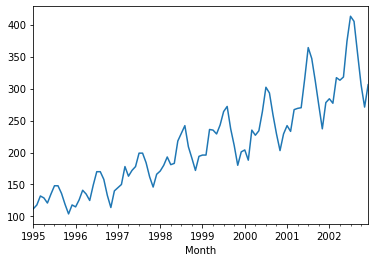

In [ ]:
data_vis.plot()

(array([13., 14., 19.,  9., 14., 12.,  9.,  1.,  3.,  2.]),
 array([104. , 134.9, 165.8, 196.7, 227.6, 258.5, 289.4, 320.3, 351.2,
        382.1, 413. ]),
 <a list of 10 Patch objects>)

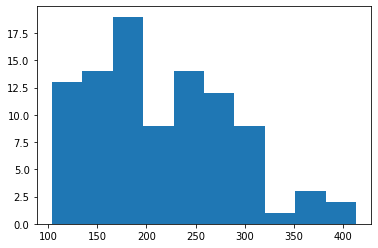

In [9]:
plt.hist(data_vis)

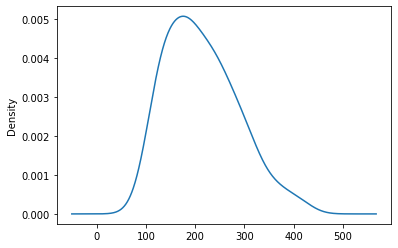

In [10]:
data_vis.plot(kind='kde')

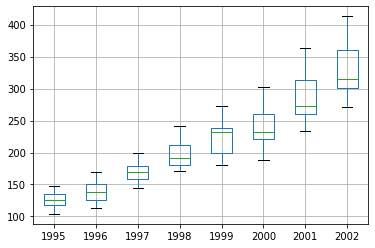

In [11]:
group=data_vis.groupby(pd.Grouper(freq='A'))
years=pd.DataFrame()
for i,j in group:
    years[i.year]=j.values
years.boxplot()
plt.show()

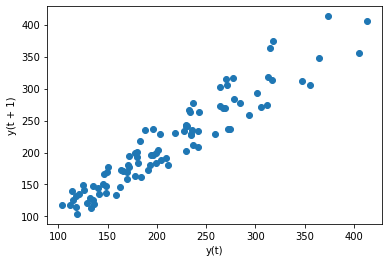

In [12]:
lag_plot(data_vis)

# performing the data driven methods on the dataset

In [13]:
train=data.head(80)# spliting the data into train and test
test=data.tail(16)

# moving average  and time decomposition plot  

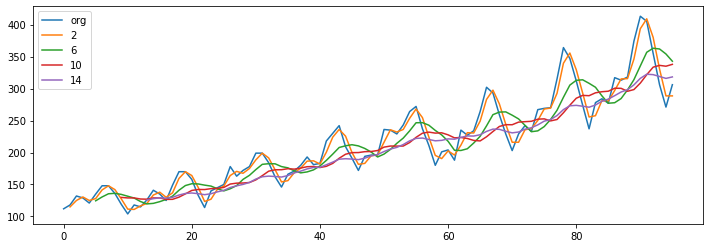

In [14]:
plt.figure(figsize=(12,4))
data.Passengers.plot(label='org')
for i in range(2,18,4):
    data['Passengers'].rolling(i).mean().plot(label=(str(i)))
plt.legend(loc='best')

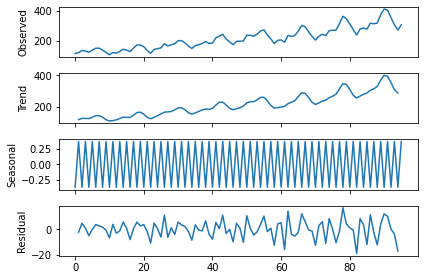

In [15]:
time_plot=seasonal_decompose(data.Passengers,freq=2)
time_plot.plot()
plt.show()

# creating my metric MAPE inorder to find the model performance

In [16]:
def Mape(pred,org):
    temp=np.abs((pred-org)/org)*100
    return np.mean(temp)

# developing the model of simple exponential  

In [17]:
train['Passengers']=train['Passengers'].astype('double')
sem_model=SimpleExpSmoothing(train['Passengers']).fit(smoothing_level=0.2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
pred_sem=sem_model.predict(start=test.index[0],end=test.index[-1])
pred_sem

80    297.434175
81    297.434175
82    297.434175
83    297.434175
84    297.434175
85    297.434175
86    297.434175
87    297.434175
88    297.434175
89    297.434175
90    297.434175
91    297.434175
92    297.434175
93    297.434175
94    297.434175
95    297.434175
dtype: float64

In [19]:
sem_mape=Mape(pred_sem,test.Passengers)
sem_mape

11.375850554268087

# developing the holt method 

In [20]:
holt_method=Holt(train['Passengers']).fit(smoothing_level=0.8,smoothing_slope=0.2)

In [21]:
holt_pred=holt_method.predict(start=test.index[0],end=test.index[-1])
holt_pred

80    366.386458
81    380.542978
82    394.699497
83    408.856016
84    423.012535
85    437.169055
86    451.325574
87    465.482093
88    479.638612
89    493.795132
90    507.951651
91    522.108170
92    536.264689
93    550.421208
94    564.577728
95    578.734247
dtype: float64

In [22]:
holt_mape=Mape(holt_pred,test.Passengers)
holt_mape

51.93443984363292

##  Holt winter exponential smoothing with additive seasonality and additive trend

In [23]:
holt_win_model = ExponentialSmoothing(train['Passengers'],seasonal="add",trend="add",seasonal_periods=12).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [24]:
holt_win_model_pred=holt_win_model.predict(start=test.index[0],end=test.index[-1])
holt_win_model_pred

80    299.544917
81    270.298533
82    245.060446
83    271.637076
84    283.528203
85    274.039369
86    312.090046
87    315.520558
88    318.933215
89    360.746614
90    402.312133
91    369.082293
92    333.750413
93    304.504029
94    279.265942
95    305.842572
dtype: float64

In [25]:
holt_win_model_mape=Mape(holt_win_model_pred,test['Passengers'])
holt_win_model_mape

2.4682346664794004

# Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [26]:
holt_win_model2 = ExponentialSmoothing(train['Passengers'],seasonal="mul",trend="add",seasonal_periods=12).fit() 

In [27]:
holt_win_model2_pred=holt_win_model2.predict(start=test.index[0],end=test.index[-1])
holt_win_model2_pred

80    310.165771
81    273.374566
82    239.332466
83    270.773627
84    276.710134
85    274.046776
86    317.627964
87    307.782755
88    306.470569
89    343.863274
90    384.045848
91    379.408030
92    336.641811
93    296.545251
94    259.475537
95    293.404176
dtype: float64

In [28]:
holt_win_model2_mape=Mape(holt_win_model2_pred,test['Passengers'])
holt_win_model2_mape

3.221305648702712

# from the above model we are using the holts winter exponential smoothing with multiplicative seasonality and additive trend because it has given the lowest value of the Mape  and applying on the entire data set

In [29]:
data['Passengers']=data['Passengers'].astype('double')

In [30]:
model=ExponentialSmoothing(data['Passengers'],seasonal="mul",trend="add",seasonal_periods=12).fit()

In [31]:
model.forecast(5)

96     312.897034
97     308.167827
98     355.528080
99     345.763587
100    345.688515
dtype: float64